# Variational Auto-Encoder

URL: https://arxiv.org/pdf/1312.6114.pdf

## Loss
+ KL-Divergence
+ Pixel-level binary cross entropy

## Model

![](../../images/vae.jpg)

## 1. Import packages

In [0]:
import os
import torch
import torch.utils.data
from torch.autograd import Variable
from torch import nn, optim
import torchvision
from torch.nn import functional as F
import torch.utils.data as Data
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import save_image

## 2. Define constants

In [0]:
num_epochs = 20
batch_size = 128
dataset_dir = 'mnist'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4

os.makedirs('images', exist_ok=True)

## 3. Prepare data

In [0]:
train_dataset = torchvision.datasets.MNIST(
        root = dataset_dir,
        train = True, # True: training data; False: testing data
#         transform = torchvision.transforms.ToTensor(), # ndarray => torch tensor
        transform = T.Compose([
               T.ToTensor(),
               T.Normalize((0.1307,), (0.3081,))
        ]),
        download = True, # whether download or not
        )

train_loader = Data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
fix_noise = torch.randn(batch_size, 20).to(device)


## 4. Build model

In [0]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = torch.nn.Linear(784, 400)
        self.fc21 = torch.nn.Linear(400, 20)
        self.fc22 = torch.nn.Linear(400, 20)
        self.fc3 = torch.nn.Linear(20, 400)
        self.fc4 = torch.nn.Linear(400, 784)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, betas=(0.9, 0.99))
        

    def encode(self, net):
        net = F.relu(self.fc1(net))
        return self.fc21(net), self.fc22(net)

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        rand = torch.randn_like(sigma)
        return mu + rand * sigma
        
    def decode(self, noise):
        h3 = F.relu(self.fc3(noise))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, net): # not underlined
        mu, logvar = self.encode(net.view(net.shape[0], -1))
        vec = self.reparameterize(mu, logvar)
        return self.decode(vec), mu, logvar

    def _loss_fn(self, recon_batch, real_image, mu, logvar):
        # pic
        bce = F.binary_cross_entropy(recon_batch, real_image.view(real_image.shape[0], -1), reduction='sum')
        # distribution. KL-Divergence
        kld = - 0.5 * torch.sum(logvar - torch.exp(logvar) - mu ** 2 + 1)

        return bce + kld
  
    def fit(self, dataloader):
        model.train()
        for index, (imgs, labels) in enumerate(dataloader):
#             imgs = Variable(imgs)
            imgs = imgs.to(device)

            recon_batch, mu, logvar = self.forward(imgs) 
            loss = self._loss_fn(recon_batch, imgs, mu, logvar)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if index % 100 == 0:
                print('epoch {}: loss={}'.format(epoch, loss))

model = VAE().to(device)


## 4. Train

epoch 0: loss=70703.859375
epoch 0: loss=-441304.78125
epoch 0: loss=-656689.75
epoch 0: loss=-764395.0
epoch 0: loss=-946085.625
epoch 1: loss=-979085.5
epoch 1: loss=-1153292.0
epoch 1: loss=-1201545.25
epoch 1: loss=-1384841.25
epoch 1: loss=-1419604.75
epoch 2: loss=-1518619.5
epoch 2: loss=-1603909.875
epoch 2: loss=-1707081.375
epoch 2: loss=-1795625.875
epoch 2: loss=-1859229.125
epoch 3: loss=-1905540.875
epoch 3: loss=-1924490.5
epoch 3: loss=-2017782.5
epoch 3: loss=-1996519.875
epoch 3: loss=-2102688.5
epoch 4: loss=-2065484.0
epoch 4: loss=-2009738.25
epoch 4: loss=-2064173.0
epoch 4: loss=-2040851.375
epoch 4: loss=-1974422.25
epoch 5: loss=-2015461.75
epoch 5: loss=-2035258.75
epoch 5: loss=-1921605.625
epoch 5: loss=-1971588.75
epoch 5: loss=-1935182.25
epoch 6: loss=-1962459.125
epoch 6: loss=-1841683.875
epoch 6: loss=-1902169.125
epoch 6: loss=-1897377.25
epoch 6: loss=-1828965.75
epoch 7: loss=-1855183.625
epoch 7: loss=-1830537.125
epoch 7: loss=-1828265.375
epoch 7

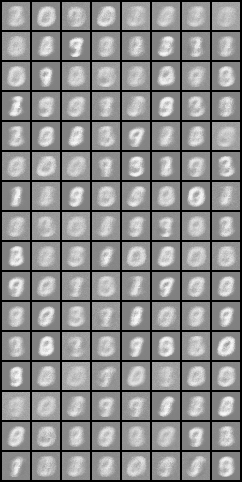

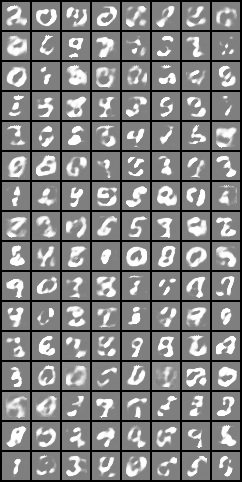

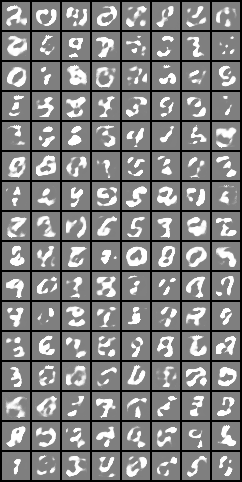

In [5]:
for epoch in range(num_epochs):
    model.fit(train_loader)

    # ------------------------------ Eval ------------------------------------------
    model.eval()
    fake_image = model.decode(fix_noise).reshape(batch_size, 1, 28, 28)
    torchvision.utils.save_image(fake_image, 'images/result_{}.png'.format(epoch + 1), normalize=True, range=(-1, 1))

from IPython.display import display, Image
display(Image(filename='images/result_1.png'))
display(Image(filename='images/result_10.png'))
display(Image(filename='images/result_20.png'))